<h1 style="color: green">Petite expérimentation personnelle sur la classification d'images en utilisant principalement des couches entièrement connectées</h1>

<h3 style="color:red">A quel point je peux avoir juste et à quel coût ?</h3>

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("swatigupta555/financial-document-classification")

print("Path to dataset files:", path)

100%|██████████| 8.37G/8.37G [02:05<00:00, 71.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/swatigupta555/financial-document-classification/versions/3


In [1]:
path="C:/Users/tanto/.cache/kagglehub/datasets/swatigupta555/financial-document-classification/versions/3"

In [79]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [80]:
import os
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [81]:
def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


In [82]:
full_path = create_images_list(create_images_list(path)[0])[0]
test_path = create_images_list(create_images_list(path)[1])[0]

In [100]:
transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

In [101]:
dataset = datasets.ImageFolder(root=full_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

In [102]:
full_path

'C:/Users/tanto/.cache/kagglehub/datasets/swatigupta555/financial-document-classification/versions/3\\Financial_Data\\Financial Data'

In [103]:
# Obtenir les indices et labels
indices = np.arange(len(dataset))
labels = [dataset.targets[i] for i in indices]  # Récupérer les labels

# Split stratifié (80% train, 20% validation)
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels, random_state=42)

# Création des sous-datasets
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Vérification
print(f"Train: {len(train_dataset)} images, Validation: {len(val_dataset)} images, test: {len(test_dataset)}")


Train: 38396 images, Validation: 9600 images, test: 39996


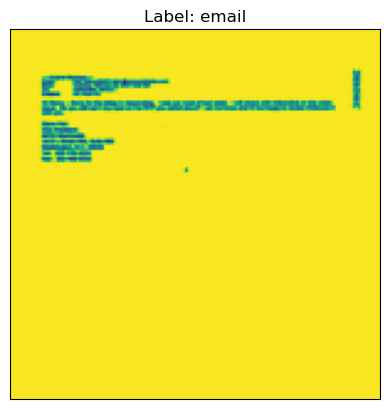

In [107]:
index_random = random.randint(0, len(dataset) - 1)

# Récupérer l'image et le label
image, label = dataset[index_random]  # `image` est un tensor, `label` est un int

# Convertir l'image Tensor en NumPy pour l'afficher avec OpenCV
image_np = image.permute(1, 2, 0).numpy()  # Convertir (C, H, W) en (H, W, C)
image_np = (image_np * 255).astype(np.uint8)  # Remettre sur l'échelle 0-255

# Afficher l'image avec Matplotlib
plt.imshow(image_np)
plt.title(f"Label: {dataset.classes[label]}")
plt.xticks([]), plt.yticks([])  # Supprimer les axes
plt.show()

In [108]:
image.shape

torch.Size([1, 150, 150])

In [109]:
test_labels = [test_dataset.targets[i] for i in range(len(test_dataset))]

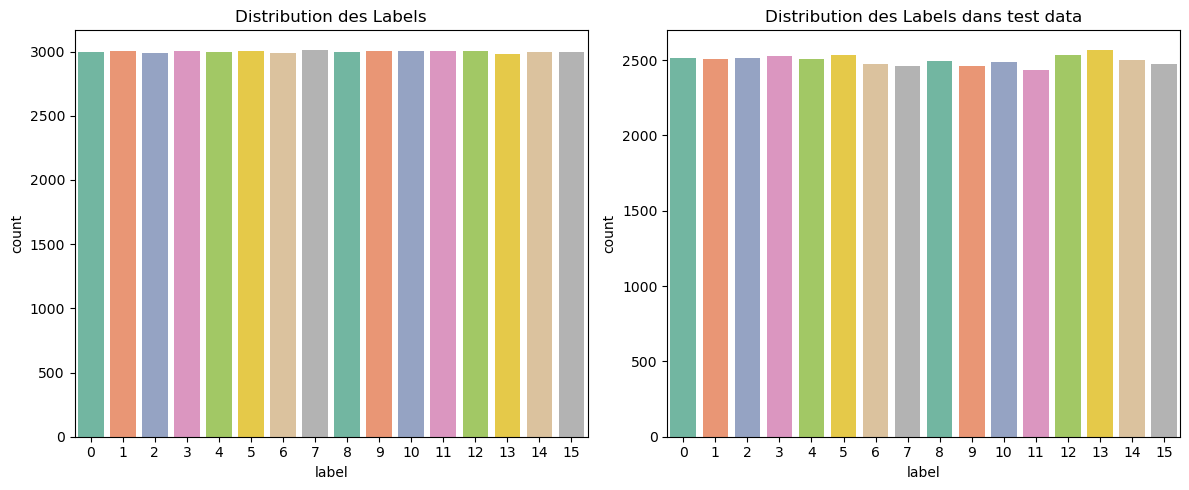

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 ligne, 2 colonnes

sns.countplot(x='label', data=pd.DataFrame(labels,columns=['label']), palette='Set2', ax=axes[0])
axes[0].set_title("Distribution des Labels")

sns.countplot(x='label', data=pd.DataFrame(test_labels,columns=['label']), palette='Set2',ax=axes[1])
axes[1].set_title("Distribution des Labels dans test data")

plt.tight_layout()
plt.show()

In [111]:
train_labels = [dataset.targets[i] for i in train_dataset.indices]
val_labels = [dataset.targets[i] for i in val_dataset.indices]

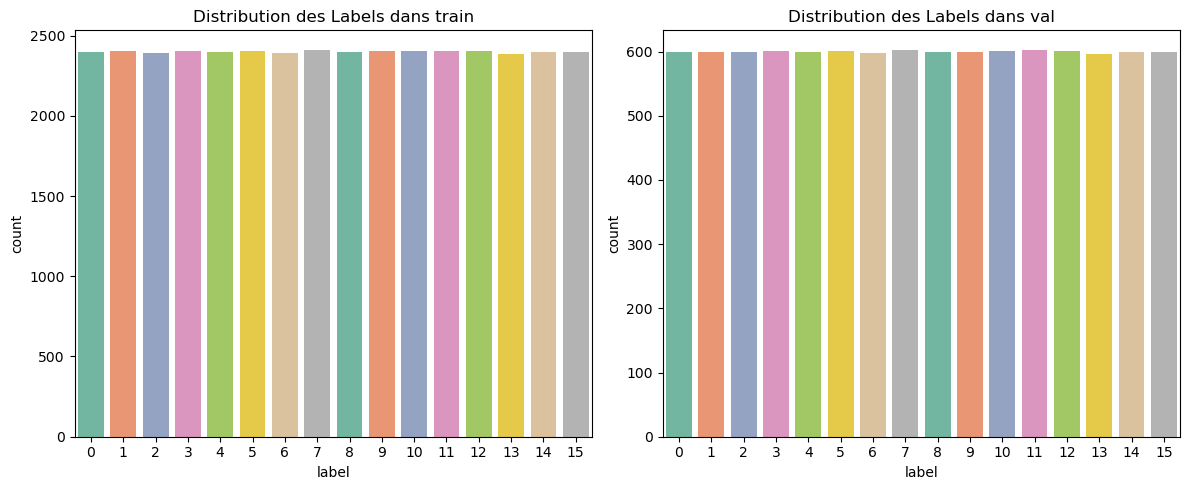

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 ligne, 2 colonnes

sns.countplot(x= 'label', data=pd.DataFrame(train_labels,columns=['label']), palette='Set2',ax =axes[0])
axes[0].set_title("Distribution des Labels dans train")

sns.countplot(x='label', data=pd.DataFrame(val_labels,columns=['label']), palette='Set2', ax =axes[1])
axes[1].set_title("Distribution des Labels dans val")

plt.tight_layout()
plt.show()

In [113]:
import torch

# Vérifier si un GPU est disponible
print("GPU disponible :", torch.cuda.is_available())

# Nom du GPU
if torch.cuda.is_available():
    print("Nom du GPU :", torch.cuda.get_device_name(0))


GPU disponible : True
Nom du GPU : NVIDIA GeForce RTX 3050 Laptop GPU


In [120]:
import torch.nn as nn

# Modèle simple avec 3 couches
model = nn.Sequential(
    nn.Flatten(),  # Applatir les images en vecteurs
    nn.BatchNorm1d(22500),
    nn.Linear(22500, 11000),  
    nn.ReLU(),
    nn.Linear(11000, 5000),  
    nn.ReLU(),
    nn.Linear(5000, 2500),  
    nn.ReLU(),# Activation ReLU
    nn.Linear(2500, 1250),  
    nn.ReLU(),# Activation ReLU
    nn.Linear(1250, 500), 
    nn.ReLU(),           # Activation ReLU
    nn.Linear(500, 256),
    nn.ReLU(),
    nn.Linear(256, 16),  # Couche 3 : 256 → 10 (sortie)
)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): BatchNorm1d(22500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=22500, out_features=11000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=11000, out_features=5000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=5000, out_features=2500, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2500, out_features=1250, bias=True)
  (9): ReLU()
  (10): Linear(in_features=1250, out_features=500, bias=True)
  (11): ReLU()
  (12): Linear(in_features=500, out_features=256, bias=True)
  (13): ReLU()
  (14): Linear(in_features=256, out_features=16, bias=True)
)


In [132]:
dataset.classes

['advertisement',
 'budget',
 'email',
 'file folder',
 'form',
 'handwritten',
 'invoice',
 'letter',
 'memo',
 'news article',
 'presentation',
 'questionnaire',
 'resume',
 'scientific publication',
 'scientific report',
 'specification']

In [121]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [130]:
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [122]:
for inputs, labels in train_loader:
        print(inputs.shape)

        break

torch.Size([64, 1, 150, 150])


In [123]:
NAME_MODEL = "model1.pth"

In [ ]:
num_epochs = 5  # Nombre d'epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Utiliser GPU si disponible
model.to(device)  # Déplacer le modèle sur le GPU

# Listes pour stocker les pertes et les précisions
train_losses = []
val_losses = []
accuracies = []
max_xaccuracy = 0

for epoch in range(num_epochs):
    model.train()  # Mettre le modèle en mode entraînement
    running_loss = 0.0

    # Entraînement
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Envoyer sur GPU

        optimizer.zero_grad()  # Réinitialiser les gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calcul de la perte
        loss.backward()  # Backpropagation
        optimizer.step()  # Mise à jour des poids

        running_loss += loss.item()

    # Enregistrer la perte moyenne d'entraînement
    train_losses.append(running_loss / len(train_loader))

    # Calcul de la précision sur les données de validation
    correct = 0
    total = 0
    model.eval()  # Mettre le modèle en mode évaluation
    val_loss = 0.0

    with torch.no_grad():  # Désactiver le calcul des gradients
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)  # Perte pour validation
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # Obtenir la classe avec la plus grande probabilité
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Enregistrer la perte et la précision pour chaque époque
    val_losses.append(val_loss / len(val_loader))
    accuracy = 100 * correct / total
    accuracies.append(accuracy)
    if accuracy > max_xaccuracy:
      max_xaccuracy = accuracy
      torch.save(model, NAME_MODEL)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}, Précision du modèle : {accuracy:.2f}%")

print("Entraînement terminé ! ✅")



In [ ]:
# Graphiques de la perte et de la précision
plt.figure(figsize=(12, 5))

# Graphique de la perte
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Perte d'entraînement")
plt.plot(range(1, num_epochs+1), val_losses, label="Perte de validation")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.title("Perte d'entraînement et de validation")
plt.legend()

# Graphique de la précision
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), accuracies, label="Précision de validation", color='orange')
plt.xlabel("Époques")
plt.ylabel("Précision (%)")
plt.title("Précision sur la validation")
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()


In [ ]:
model = torch.load(NAME_MODEL,weights_only=False).to(device)
model.eval()  # Passer en mode évaluation

In [ ]:
true_labels = []
pred_labels = []

with torch.no_grad():  # Désactiver le calcul des gradients
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Faire des prédictions
        _, predicted = torch.max(outputs, 1)  # Obtenir la classe avec la plus grande probabilité

        # Stocker les vraies étiquettes et les prédictions
        true_labels.extend(labels.cpu().numpy())  # Convertir en numpy
        pred_labels.extend(predicted.cpu().numpy())

In [127]:
print(classification_report(true_labels, pred_labels, target_names=dataset.classes))


                        precision    recall  f1-score   support

         advertisement       0.67      0.51      0.58      2515
                budget       0.41      0.56      0.47      2505
                 email       0.87      0.90      0.89      2516
           file folder       0.65      0.76      0.70      2527
                  form       0.40      0.26      0.31      2506
           handwritten       0.76      0.66      0.70      2532
               invoice       0.56      0.42      0.48      2477
                letter       0.48      0.63      0.54      2464
                  memo       0.44      0.59      0.51      2492
          news article       0.49      0.56      0.52      2463
          presentation       0.54      0.23      0.32      2489
         questionnaire       0.30      0.52      0.38      2435
                resume       0.75      0.73      0.74      2536
scientific publication       0.63      0.53      0.58      2569
     scientific report       0.35      

In [128]:
# Calcul de la matrice de confusion
cm = confusion_matrix(true_labels, pred_labels)
report = pd.DataFrame(cm,columns=dataset.classes, index=dataset.classes)

In [129]:
report

,advertisement,budget,email,file folder,form,handwritten,invoice,letter,memo,news article,presentation,questionnaire,resume,scientific publication,scientific report,specification
advertisement,1279,37,13,403,15,71,18,71,33,337,9,125,16,53,13,22
budget,17,1397,41,51,105,5,138,46,116,98,38,214,18,32,108,81
email,1,32,2258,12,0,14,3,51,65,3,3,27,15,4,14,14
file folder,110,96,24,1925,8,20,63,6,14,34,23,27,4,62,91,20
form,24,281,10,36,642,93,162,174,139,74,49,460,43,49,134,136
handwritten,76,11,12,20,15,1660,19,245,9,7,2,305,12,24,5,110
invoice,28,222,17,63,142,76,1045,196,130,67,41,180,19,76,56,119
letter,18,27,27,17,27,79,42,1551,273,22,20,189,47,28,41,56
memo,15,86,38,25,53,4,39,285,1474,28,41,238,43,27,56,40
news article,173,148,32,61,41,6,40,50,99,1367,53,101,38,178,64,12
